In [45]:
#import libraries
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader
from MyDataset import CustomTimeSeriesDataset
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import random_split
import torch.nn.functional as F
import torch
import os

In [86]:
#Initialize dataset and do train validation split

#Fix random seed for reproducibility
torch.manual_seed(1)
np.random.seed(1)

# Data already minmaxed
dataset = CustomTimeSeriesDataset('ptbdb_train.csv', LSTM=True)

# Define the split sizes. In this case, 70% for training and 30% for validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Create two Datasets from the original one
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#Initialize dataloaders
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

def created_weighted_sampler_dataloader(dataset_subset, batch, repl=True):
    target=dataset_subset.dataset.labels[dataset_subset.indices]
    class_sample_count = np.array(    [len(np.where(target == t)[0]) for t in np.unique(target)])
    weight = 1. / class_sample_count ###ATENCAO
    weight=weight/weight.sum()
    samples_weight = torch.tensor([weight[int(t)] for t in target]).double()    
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=repl)    
    return DataLoader(dataset_subset, batch_size=batch, sampler=sampler)

#Choose how to load the training data
#train_loader = created_weighted_sampler_dataloader(train_dataset, repl=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True) #was not using this because of the weighted sampler

#ALL BATCHES HAVE APPROX SIMILAR POSITIVE AND NEGATIVE SAMPLES
for i, (data, targetmy) in enumerate(train_loader):
   print(f"batch index {i}, 0/1: {len(np.where(targetmy.numpy() == 0)[0])}/{len(np.where(targetmy.numpy() == 1)[0])}")


batch index 0, 0/1: 40/88
batch index 1, 0/1: 30/98
batch index 2, 0/1: 45/83
batch index 3, 0/1: 35/93
batch index 4, 0/1: 32/96
batch index 5, 0/1: 30/98
batch index 6, 0/1: 33/95
batch index 7, 0/1: 41/87
batch index 8, 0/1: 42/86
batch index 9, 0/1: 33/95
batch index 10, 0/1: 40/88
batch index 11, 0/1: 33/95
batch index 12, 0/1: 44/84
batch index 13, 0/1: 37/91
batch index 14, 0/1: 42/86
batch index 15, 0/1: 42/86
batch index 16, 0/1: 46/82
batch index 17, 0/1: 44/84
batch index 18, 0/1: 34/94
batch index 19, 0/1: 41/87
batch index 20, 0/1: 33/95
batch index 21, 0/1: 31/97
batch index 22, 0/1: 36/92
batch index 23, 0/1: 40/88
batch index 24, 0/1: 38/90
batch index 25, 0/1: 41/87
batch index 26, 0/1: 37/91
batch index 27, 0/1: 33/95
batch index 28, 0/1: 34/94
batch index 29, 0/1: 29/99
batch index 30, 0/1: 31/97
batch index 31, 0/1: 35/93
batch index 32, 0/1: 29/99
batch index 33, 0/1: 42/86
batch index 34, 0/1: 38/90
batch index 35, 0/1: 32/96
batch index 36, 0/1: 31/97
batch index

In [87]:
#Define my LSTM model
class simpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0):
        super(simpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,dropout=dropout_rate, batch_first=True, bias=False)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        #OUTPUT IS NOT A PROBABILITY; SO WE USE BCEWithLogitsLoss
        return out
    
#Define my LSTM model
class vanillaLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0):
        super(vanillaLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64,1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        _, (_,cf) = self.lstm(x, (h0, c0))
        out = F.elu(cf[-1, :, :]) #try to escape local minima
        out = self.fc(out)
        out = F.elu(out)
        out = self.fc2(out)
        #OUTPUT IS NOT A PROBABILITY; SO WE USE BCEWithLogitsLoss
        return out

# Create new bidirectional LSTM
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout_rate, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64,1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        _, (_,cf) = self.lstm(x, (h0, c0))
        out = F.elu(cf[-1, :, :]) #try to escape local minima
        out = self.fc(out)
        out = F.elu(out)
        out = self.fc2(out)
        #OUTPUT IS NOT A PROBABILITY; SO WE USE BCEWithLogitsLoss
        return out

In [89]:
#Train the model

#If we want to continue training from a previous model
#model.load_state_dict(torch.load(os.path.join('Model_Parameters', 'RNN1_best_parameters.pth')))

#Initialize train dataloader
train_loader = created_weighted_sampler_dataloader(train_dataset, batch=512, repl=True)
#train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True) #was not using this because of the weighted sampler

#Initializef validation loader
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

name="simpleLSTM"
model = simpleLSTM(input_size=1, hidden_size=64, num_layers=2, dropout_rate=0)

#Define loss function and optimizer as BCEWithLogitsLoss, as output is not a probability
criterion = nn.BCEWithLogitsLoss()

#Define optimizer as SGD with a lot of hyperparameters to avoid local minima (no dropout or regularization, we are trying to overfit here)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0, nesterov=True)

#Learning rate scheduler
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Number of epochs
n_epochs = 250

#Sent model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

# Loop over the dataset multiple times
#make initial validation loss infinite
val_loss = float('inf')
all_train_acc = []
all_val_acc = []
all_outputs = []
all_labels = []

for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    #step the learning rate scheduler
    #scheduler.step(val_loss)

    # Training loop
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if i==0:
            predicted = torch.round(outputs)
            #print first batch accuracy
            total=labels.size(0)
            correct=(predicted == labels).sum().item()
            acc=100 * correct / total
            print(f'Epoch {epoch+1}/{n_epochs}, Batch {i+1}/{len(train_loader)}, Accuracy: {acc}%')

        #Save the accuracies of all batches
        all_train_acc.append(acc)

        #Save the outputs and correct labels of all batches, as numpy arrays
        all_outputs.append(outputs.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())

    # Validation loop
    model.eval()  # Set model to evaluation mode
    total = 0
    correct = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    #compute validation correct labels
    val_accuracy=100 * correct / total
    all_val_acc.append(val_accuracy)
    print(f'Epoch {epoch+1}/{n_epochs}, Validation Acc: {val_accuracy}%')

    #keep track of best model if validation loss is minimum
    if val_accuracy == max(all_val_acc):
        best_model = model
        
print('Finished Training')

# Save the best model parameters
#btorch.save(best_model.state_dict(), os.path.join('Model_Parameters', f'{name}_best_hs:{best_model.hidden_size}_{best_model.num_layers}layers.pth'))

cuda
Epoch 1/250, Batch 1/19, Accuracy: 49.4140625%
Epoch 1/250, Validation Acc: 27.74914089347079%
Epoch 2/250, Batch 1/19, Accuracy: 50.5859375%
Epoch 2/250, Validation Acc: 27.74914089347079%
Epoch 3/250, Batch 1/19, Accuracy: 49.0234375%
Epoch 3/250, Validation Acc: 27.74914089347079%
Epoch 4/250, Batch 1/19, Accuracy: 47.0703125%
Epoch 4/250, Validation Acc: 27.74914089347079%
Epoch 5/250, Batch 1/19, Accuracy: 51.171875%
Epoch 5/250, Validation Acc: 27.74914089347079%
Epoch 6/250, Batch 1/19, Accuracy: 46.484375%
Epoch 6/250, Validation Acc: 27.74914089347079%
Epoch 7/250, Batch 1/19, Accuracy: 45.703125%
Epoch 7/250, Validation Acc: 27.74914089347079%
Epoch 8/250, Batch 1/19, Accuracy: 50.5859375%
Epoch 8/250, Validation Acc: 27.74914089347079%
Epoch 9/250, Batch 1/19, Accuracy: 50.1953125%
Epoch 9/250, Validation Acc: 27.74914089347079%
Epoch 10/250, Batch 1/19, Accuracy: 53.90625%
Epoch 10/250, Validation Acc: 27.74914089347079%
Epoch 11/250, Batch 1/19, Accuracy: 49.8046875%


In [90]:
hidden_size=64
num_layers=2
name="simpleLSTM"
#Save current model
torch.save(best_model.state_dict(), os.path.join('Model_Parameters', f'{name}_best_hs:{best_model.hidden_size}_{best_model.num_layers}layers.pth'))

#load model
model = simpleLSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=0)
model.load_state_dict(torch.load(os.path.join('Model_Parameters', f'{name}_best_hs:{hidden_size}_{num_layers}layers.pth')))


<All keys matched successfully>

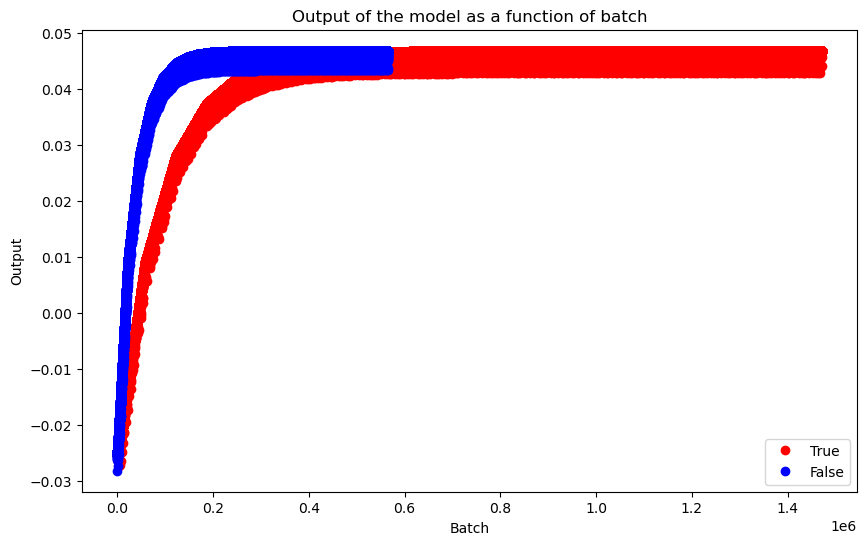

In [85]:
#Plot outputs of the model as a functino of batches. Separately for true and false labels. Use all_outputs and all_labels
import matplotlib.pyplot as plt

all_outputs2 = np.concatenate(all_outputs)
all_labels2 = np.concatenate(all_labels)

#downsample by 100
all_outputs2=all_outputs2[::]
all_labels2=all_labels2[::]

#big figure
plt.figure(figsize=(10,6))
plt.plot(all_outputs2[all_labels2==1], 'ro', label='True')
plt.plot(all_outputs2[all_labels2==0], 'bo', label='False')
plt.legend()
plt.xlabel('Batch')
plt.ylabel('Output')
plt.title('Output of the model as a function of batch')
plt.show()

Predicted_vs_actual: [[0.9793832  0.        ]
 [0.9837827  0.        ]
 [0.96976507 1.        ]
 [0.97409344 1.        ]
 [0.94957536 1.        ]
 [0.98545116 1.        ]
 [1.0003777  1.        ]
 [0.9867976  1.        ]
 [0.99249077 1.        ]
 [0.98205566 1.        ]
 [0.9764153  1.        ]
 [0.97046643 1.        ]
 [0.95823926 1.        ]
 [0.9655009  1.        ]
 [1.0066861  1.        ]
 [0.9744397  0.        ]
 [0.97963786 0.        ]
 [0.9951947  1.        ]
 [0.9841765  1.        ]
 [0.96216136 0.        ]
 [0.9692559  1.        ]
 [0.9625969  1.        ]
 [0.9842316  1.        ]
 [0.98288053 1.        ]
 [1.0028067  1.        ]
 [0.94988346 0.        ]
 [0.96437335 0.        ]
 [0.9611191  1.        ]
 [1.0141952  1.        ]
 [0.98188806 1.        ]
 [0.9799562  1.        ]
 [0.9803004  0.        ]
 [0.99274594 0.        ]
 [0.96719265 1.        ]
 [0.9834109  1.        ]
 [0.96975374 0.        ]
 [0.9596776  0.        ]
 [0.96478623 0.        ]
 [0.9779048  1.        ]
 [0.

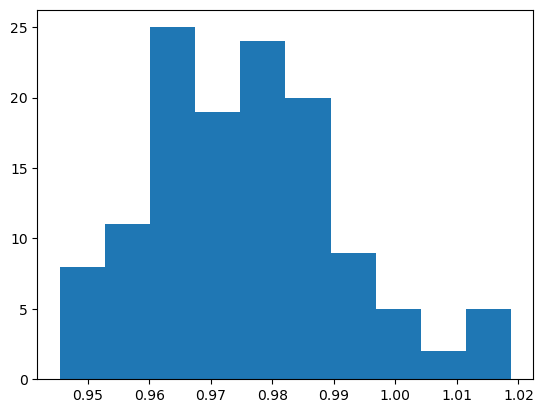

In [40]:
#plot validation loss, predictions and actual labels
import matplotlib.pyplot as plt


# Show prediction for different elements in validation set
model.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        predicted = torch.round(outputs)

        # Create a Nx2 array with the predicted and actual labels
        outputs = outputs.cpu().numpy()
        predicted = predicted.cpu().numpy()
        labels = labels.cpu().numpy()

        #merge the arrays
        predicted_vs_actual = np.concatenate((outputs, labels), axis=1)

        #make histogram of outputs
        plt.hist(outputs)
        print('Predicted_vs_actual:', predicted_vs_actual)
        break

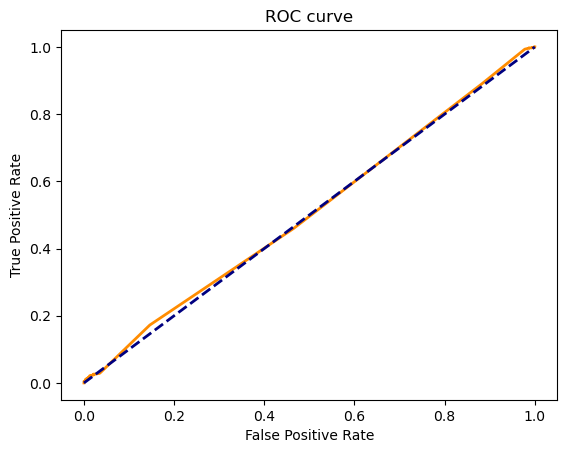

Test ROC AUC: 0.5063097026876807


In [253]:
#Plot ROC curve
from sklearn.metrics import roc_auc_score

#Prepare test dataset
dataset_test = CustomTimeSeriesDataset('ptbdb_test.csv', LSTM=True)
test_loader = DataLoader(dataset_test, batch_size=128, shuffle=False)

#Load the model parameters
#model = LSTM(input_size=1, hidden_size=100, num_layers=3)
#model.load_state_dict(torch.load(os.path.join('Model_Parameters', 'RNN1_parameters.pth')))
#model.to(device)

# Test loop
model.eval()  # Set model to evaluation mode
all_preds = []
all_labels = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Store predictions and true labels
        all_preds.extend(outputs.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

#Plot ROC
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(all_labels, all_preds)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# Compute ROC AUC for the test set
roc_auc = roc_auc_score(all_labels, all_preds)

print(f'Test ROC AUC: {roc_auc}')